In [4]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import time
import pickle

In [5]:
from multioutput_functions import *

In [6]:
singles = pd.read_hdf(r'C:/Users/juand/Research/h5_files/singles_230801.h5')
singles.drop(['OLD_SPT','MKO_J', 'MKO_H', 'MKO_K', '2MASS_J', '2MASS_H', '2MASS_KS','NAME'],axis=1,inplace=True)
singles

,WAVE,FLUX,UNCERTAINTY,J_SNR,SPT
0,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[1.9660627713093847e-10, 2.1131039893243844e-1...","[5.982245325049133e-12, 5.755711185801827e-12,...",94.018303,M6.0
1,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[1.9950771920752281e-10, 2.079591490944689e-10...","[7.703832533018333e-13, 1.0951267822400711e-12...",386.537811,M7.0
2,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[1.9762911463072993e-10, 2.0580528498234088e-1...","[2.2989224859548107e-12, 2.3022679333025286e-1...",204.598099,M6.0
3,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[2.2878515319813078e-10, 2.370316420618723e-10...","[6.1214909391048044e-12, 6.136043777530829e-12...",91.589699,M6.0
4,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[2.0618668468240422e-10, 2.142866617637176e-10...","[1.0832266058640476e-12, 1.0976881329239517e-1...",414.787994,M6.0
...,...,...,...,...,...
1044,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[2.3139820970701434e-13, 1.246237555225135e-13...","[1.2961283330524777e-13, 1.2520460658453793e-1...",4.703918,T8.0
1045,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[5.244854443773445e-14, 6.580743947046151e-14,...","[3.029490952427518e-14, 2.968834229762724e-14,...",23.436972,T8.0
1046,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[-2.2614582467991454e-14, 5.872129739165835e-1...","[4.4876320743869606e-14, 4.616998222544605e-14...",13.918951,T8.0
1047,"[0.90129393, 0.9047135, 0.9081512, 0.9116069, ...","[1.4678859815360097e-14, 1.7897430190283215e-1...","[6.009617385156795e-15, 6.170117985714561e-15,...",30.023281,T9.0


In [7]:
wave = singles['WAVE'][0]
wavegrid_list=list(wave)
wave = np.array(wave)
wavegrid=wave

In [8]:
df = pd.read_hdf(r'C:/Users/juand/Research/h5_files/standards_230801.h5').reset_index(drop=True)
STANDARDS = {
    "WAVE": df["WAVE"].iloc[0],
    "SPT": df["SPT"],
    "FLUX": df["FLUX"],
    "UNC": df["UNCERTAINTY"],
}

In [9]:
typenum=[]
for i in range(len(singles)):
    typenum.append(typeToNum(singles['SPT'][i]))
singles['SPT_NUM']=typenum
singles = singles.loc[singles['SPT_NUM']>15*np.ones(len(singles))]
singles = singles.reset_index(drop=True)

In [10]:
snrclass=[]
for i in range(len(singles)):
    snrQ = singles['J_SNR'][i]
    if snrQ<50:
        snrclass.append('low')
    elif (snrQ>=50)&(snrQ<100):
        snrclass.append('mid')
    else:
        snrclass.append('hig')
singles['SNR_CLASS']=snrclass

In [11]:
drop_unc = []
for position, uncertainty_i in enumerate(np.array(singles['UNCERTAINTY'])):
    if np.any(uncertainty_i<0)|np.any(np.isnan(uncertainty_i))|np.any(np.isinf(uncertainty_i)):
        drop_unc.append(position)
singles = singles.drop(drop_unc).reset_index(drop=True)

In [12]:
def fast_classify2(
    wave,
    flux,
    unc,
    fit_range=[0.9, 2.4],
    standards=STANDARDS,
    telluric=False,
    method="full",
):

    if method == "kirkpatrick":
        fit_range = [0.9, 1.4]
    elif method == "full":
        fit_range = [0.9, 2.4]
    else:
        pass

    w = np.where(np.logical_and(wave >= fit_range[0], wave <= fit_range[1]))[0]

    scales, chi = [], []

    weights = np.ones(len(wave))

    if telluric == True:
        msk = np.ones(len(weights))
        msk[
            np.where(
                np.logical_or(
                    np.logical_and(wavegrid > 1.35, wavegrid < 1.42),
                    np.logical_and(wavegrid > 1.8, wavegrid < 1.95),
                )
            )
        ] = 0
        weights = weights * msk

    # Loop through standards
    for std in standards["FLUX"]:
        scale = np.nansum(weights * (flux * std) / (unc**2)) / np.nansum(
            (weights * std**2) / (unc**2)
        )
        scales.append(scale)
        chisquared = np.nansum(
            weights * ((flux - (std * scales[-1])) ** 2) / (unc**2)
        )
        chi.append(chisquared)
    
    return standards["SPT"][np.argmin(chi)]

In [13]:
s17low = singles[(singles.SPT_NUM==17)&(singles.SNR_CLASS=='low')].reset_index(drop=True)
f17low, u17low = normalize(wave,s17low.FLUX[1],s17low.UNCERTAINTY[1])
s24low = singles[(singles.SPT_NUM==24)&(singles.SNR_CLASS=='low')].reset_index(drop=True)
f24low, u24low = normalize(wave,s24low.FLUX[0],s24low.UNCERTAINTY[0])

s17mid = singles[(singles.SPT_NUM==17)&(singles.SNR_CLASS=='mid')].reset_index(drop=True)
f17mid, u17mid = normalize(wave,s17mid.FLUX[1],s17mid.UNCERTAINTY[1])
s24mid = singles[(singles.SPT_NUM==24)&(singles.SNR_CLASS=='mid')].reset_index(drop=True)
f24mid, u24mid = normalize(wave,s24mid.FLUX[1],s24mid.UNCERTAINTY[1])

s17hig = singles[(singles.SPT_NUM==17)&(singles.SNR_CLASS=='hig')].reset_index(drop=True)
f17hig, u17hig = normalize(wave,s17hig.FLUX[0],s17hig.UNCERTAINTY[0])
s24hig = singles[(singles.SPT_NUM==24)&(singles.SNR_CLASS=='hig')].reset_index(drop=True)
f24hig, u24hig = normalize(wave,s24hig.FLUX[0],s24hig.UNCERTAINTY[0])

In [14]:
binlow = f17low+f24low
ulow   = u17low+u24low
binlow, ulow = normalize(wave,binlow,ulow)
Slow = df[df.SPT==fast_classify2(wave,binlow,ulow)].reset_index(drop=True)
Sflow, Sulow = normalize(wave,Slow.FLUX[0],Slow.UNCERTAINTY[0])
dlow = binlow-Sflow

binmid = f17mid+f24mid
umid   = u17mid+u24mid
binmid, umid = normalize(wave,binmid,umid)
Smid = df[df.SPT==fast_classify2(wave,binmid,umid)].reset_index(drop=True)
Sfmid, Sumid = normalize(wave,Smid.FLUX[0],Smid.UNCERTAINTY[0])
dmid = binmid-Sfmid

binhig = f17hig+f24hig
uhig   = u17hig+u24hig
binhig, uhig = normalize(wave,binhig,uhig)
Shig = df[df.SPT==fast_classify2(wave,binhig,uhig)].reset_index(drop=True)
Sfhig, Suhig = normalize(wave,Shig.FLUX[0],Shig.UNCERTAINTY[0])
dhig = binhig-Sfhig

LOW, TELLURIC

In [20]:
with open('data/BinDF_low.pickle', 'rb') as f:
        BinDF_low = pickle.load(f)

In [21]:
start = time.time()
clflow_T, data_low_T = binary_multiOutput_classifier(BinDF_low,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

910.289608001709


In [22]:
yput1 = []
yput2 = []
for i in data_low_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_low_T_df = pd.DataFrame(data_low_T['x_test'])
data_low_T_df['prim']=yput1
data_low_T_df['seco']=yput2
data_low_T_df.to_csv('data/data_low_T_50est.csv',index=False)

In [23]:
x_test_low_T = data_low_T['x_test']
y_test_low_T = data_low_T['y_test']
print(len(x_test_low_T))

18000


In [24]:
joblib.dump(clflow_T, 'MOclassifiers/MO_low_T_50est.pkl')

['MOclassifiers/MO_low_T_50est.pkl']

In [75]:
MO_low_T = joblib.load('MOclassifiers/MO_low_T_50est.pkl')

In [76]:
df_data_low_T = pd.read_csv(r'data/data_low_T_50est.csv')
x_test_low_T = [[df_data_low_T[str(col)][i] for col in range(351)] for i in range(len(df_data_low_T))]
y_test_low_T = [[df_data_low_T['prim'][i],df_data_low_T['seco'][i]] for i in range(len(df_data_low_T))]

In [77]:
start = time.time()
df_avgdiffprim_low_T, df_avgdiffseco_low_T, df_stdprim_low_T, df_stdseco_low_T, predsprim_low_T, predssec_low_T, realprim_low_T, realsec_low_T = binaryPrecision(x_test_low_T,y_test_low_T,MO_low_T, predictions=True)
end = time.time()
print(end-start)

76.31781911849976


-0.08596537894805895


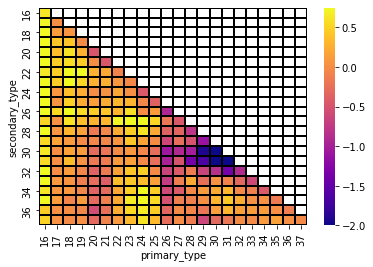

In [28]:
sns.heatmap(df_avgdiffprim_low_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_low_T.mean(axis = 0, skipna = True).mean())

-0.028173279871318197


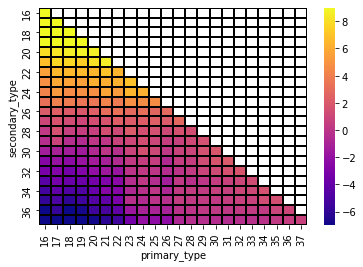

In [29]:
sns.heatmap(df_avgdiffseco_low_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_low_T.mean(axis = 0, skipna = True).mean())

0.8778410478596329


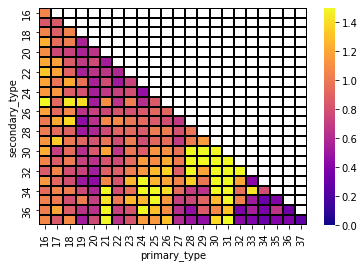

In [30]:
sns.heatmap(df_stdprim_low_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_low_T.mean(axis = 0, skipna = True).mean())

1.1033256856634763


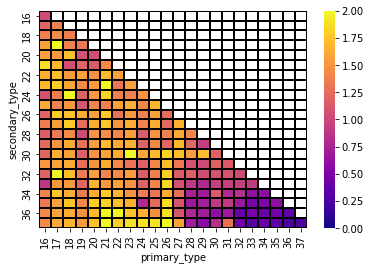

In [31]:
sns.heatmap(df_stdseco_low_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_low_T.mean(axis = 0, skipna = True).mean())

409
409


{'primary_type': {'wavegrid': [1.0072784,
   1.0111604,
   1.1161318,
   1.1665872,
   1.1708316,
   1.175081,
   1.3428532],
  'importance': [0.02772112566272719,
   0.021369294147742995,
   0.15054368158256606,
   0.24605199716413928,
   0.09841728943773298,
   0.031692425541111305,
   0.1737871818358299]},
 'secondary_type': {'wavegrid': [1.1202984,
   1.1708316,
   1.175081,
   1.1793355,
   1.1835947,
   1.1878585,
   1.1921266,
   1.3083439,
   1.3126608,
   1.3428532,
   1.6582698],
  'importance': [0.0054173158609264705,
   0.0966247323985399,
   0.036331992782621066,
   0.04818807195682196,
   0.04776485372858926,
   0.03204055054327348,
   0.0063122063792269865,
   0.007242882704254152,
   0.006733037463640229,
   0.005255730233146076,
   0.004924393212376683]}}

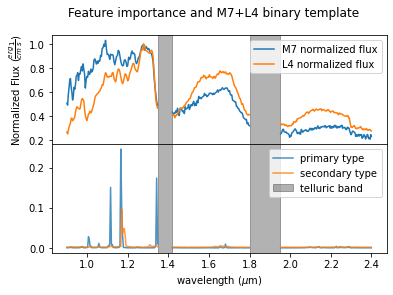

In [78]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = f17low
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
xarr = f24low
for i in tm:
    xarr[i] = np.nan
xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])

feat_impts_low_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_low_T.estimators_:
    tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    print(len(FI))
    ax[1].plot(wvgrd,FI, alpha=0.8)
    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        dd.append(wvgrd[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type', 'telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')
feat_impts_low_T['primary_type']['wavegrid'] = ddd[0]
feat_impts_low_T['primary_type']['importance'] = eee[0]
feat_impts_low_T['secondary_type']['wavegrid'] = ddd[1]
feat_impts_low_T['secondary_type']['importance'] = eee[1]
feat_impts_low_T

In [33]:
precisionprim_lowT1, recallprim_lowT1, f1_scoreprim_lowT1, accuracyprim_lowT1 = calculate_metrics(realprim_low_T,predsprim_low_T,1)
precisionsec_lowT1, recallsec_lowT1, f1_scoresec_lowT1, accuracysec_lowT1 = calculate_metrics(realsec_low_T,predssec_low_T,1)
precisionprim_lowT3, recallprim_lowT3, f1_scoreprim_lowT3, accuracyprim_lowT3 = calculate_metrics(realprim_low_T,predsprim_low_T,3)
precisionsec_lowT3, recallsec_lowT3, f1_scoresec_lowT3, accuracysec_lowT3 = calculate_metrics(realsec_low_T,predssec_low_T,3)

In [34]:
with open('data/precisionprim_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_lowT1, file)
with open('data/recallprim_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_lowT1, file)
with open('data/f1_scoreprim_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_lowT1, file)
with open('data/accuracyprim_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_lowT1, file)

In [35]:
with open('data/precisionsec_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_lowT1, file)
with open('data/recallsec_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_lowT1, file)
with open('data/f1_scoresec_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_lowT1, file)
with open('data/accuracysec_lowT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_lowT1, file)

In [36]:
with open('data/precisionprim_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_lowT3, file)
with open('data/recallprim_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_lowT3, file)
with open('data/f1_scoreprim_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_lowT3, file)
with open('data/accuracyprim_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_lowT3, file)

In [37]:
with open('data/precisionsec_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_lowT3, file)
with open('data/recallsec_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_lowT3, file)
with open('data/f1_scoresec_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_lowT3, file)
with open('data/accuracysec_lowT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_lowT3, file)

MID, TELLURIC

In [38]:
with open('data/BinDF_mid.pickle', 'rb') as f:
        BinDF_mid = pickle.load(f)

In [39]:
start = time.time()
clfmid_T, data_mid_T = binary_multiOutput_classifier(BinDF_mid,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

813.1296377182007


In [40]:
len(data_mid_T['x_test'][0])

351

In [41]:
yput1 = []
yput2 = []
for i in data_mid_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_mid_T_df = pd.DataFrame(data_mid_T['x_test'])
data_mid_T_df['prim']=yput1
data_mid_T_df['seco']=yput2
data_mid_T_df.to_csv('data/data_mid_T_50est.csv',index=False)

In [42]:
x_test_mid_T = data_mid_T['x_test']
y_test_mid_T = data_mid_T['y_test']
print(len(x_test_mid_T))

16560


In [43]:
joblib.dump(clfmid_T, 'MOclassifiers/MO_mid_T_50est.pkl')

['MOclassifiers/MO_mid_T_50est.pkl']

In [79]:
MO_mid_T = joblib.load('MOclassifiers/MO_mid_T_50est.pkl')

In [81]:
df_data_mid_T = pd.read_csv(r'data/data_mid_T_50est.csv')
x_test_mid_T = [[df_data_mid_T[str(col)][i] for col in range(351)] for i in range(len(df_data_mid_T))]
y_test_mid_T = [[df_data_mid_T['prim'][i],df_data_mid_T['seco'][i]] for i in range(len(df_data_mid_T))]

In [45]:
start = time.time()
df_avgdiffprim_mid_T, df_avgdiffseco_mid_T, df_stdprim_mid_T, df_stdseco_mid_T, predsprim_mid_T, predssec_mid_T, realprim_mid_T, realsec_mid_T = binaryPrecision(x_test_mid_T,y_test_mid_T,MO_mid_T, predictions=True)
end = time.time()
print(end-start)

74.41894006729126


-0.034011025574392485


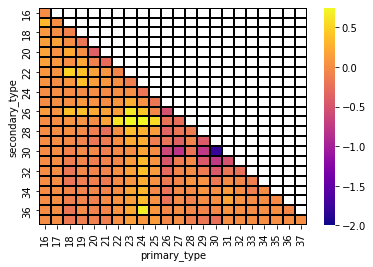

In [46]:
sns.heatmap(df_avgdiffprim_mid_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_mid_T.mean(axis = 0, skipna = True).mean())

-0.05847508267249385


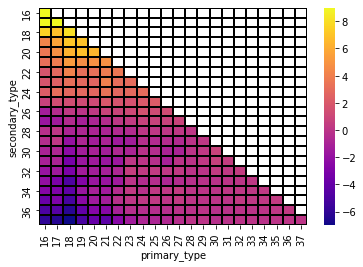

In [47]:
sns.heatmap(df_avgdiffseco_mid_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_mid_T.mean(axis = 0, skipna = True).mean())

0.3524989487981397


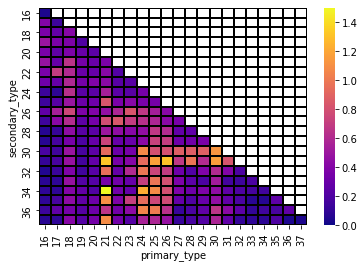

In [48]:
sns.heatmap(df_stdprim_mid_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_mid_T.mean(axis = 0, skipna = True).mean())

0.9232098329430971


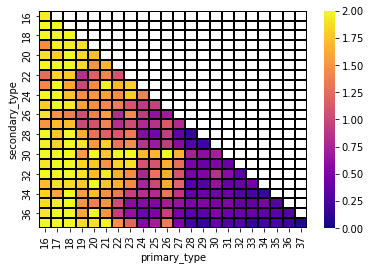

In [49]:
sns.heatmap(df_stdseco_mid_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_mid_T.mean(axis = 0, skipna = True).mean())

409
409


{'primary_type': {'wavegrid': [1.0546899,
   1.1202984,
   1.1244725,
   1.128654,
   2.3795228],
  'importance': [0.05303546363637158,
   0.33669249183033056,
   0.16140583314748194,
   0.14839009852107118,
   0.10356525162176232]},
 'secondary_type': {'wavegrid': [1.1878585,
   1.1921266,
   1.2006752,
   1.3256073,
   1.6739404,
   2.2054515],
  'importance': [0.20610844599506958,
   0.08799014788440886,
   0.029011495722224057,
   0.026439684503294942,
   0.019203914968024795,
   0.013807035901792702]}}

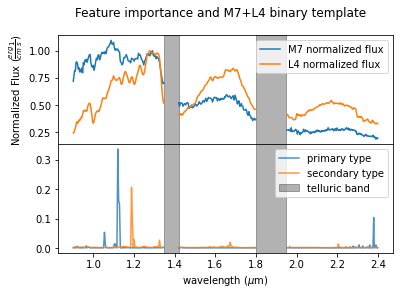

In [82]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = f17mid
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
# xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
xarr = f24mid
for i in tm:
    xarr[i] = np.nan
# xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])

feat_impts_mid_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_mid_T.estimators_:
    tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    print(len(FI))
    ax[1].plot(wvgrd,FI, alpha=0.8)
    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        dd.append(wvgrd[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type', 'telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')
feat_impts_mid_T['primary_type']['wavegrid'] = ddd[0]
feat_impts_mid_T['primary_type']['importance'] = eee[0]
feat_impts_mid_T['secondary_type']['wavegrid'] = ddd[1]
feat_impts_mid_T['secondary_type']['importance'] = eee[1]
feat_impts_mid_T

In [51]:
precisionprim_midT1, recallprim_midT1, f1_scoreprim_midT1, accuracyprim_midT1 = calculate_metrics(realprim_mid_T,predsprim_mid_T,1)
precisionsec_midT1, recallsec_midT1, f1_scoresec_midT1, accuracysec_midT1 = calculate_metrics(realsec_mid_T,predssec_mid_T,1)
precisionprim_midT3, recallprim_midT3, f1_scoreprim_midT3, accuracyprim_midT3 = calculate_metrics(realprim_mid_T,predsprim_mid_T,3)
precisionsec_midT3, recallsec_midT3, f1_scoresec_midT3, accuracysec_midT3 = calculate_metrics(realsec_mid_T,predssec_mid_T,3)

In [52]:
with open('data/precisionprim_midT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_midT1, file)
with open('data/recallprim_midT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_midT1, file)
with open('data/f1_scoreprim_midT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_midT1, file)
with open('data/accuracyprim_midT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_midT1, file)

In [53]:
with open('data/precisionsec_midT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_midT1, file)
with open('data/recallsec_midT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_midT1, file)
with open('data/f1_scoresec_midT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_midT1, file)
with open('data/accuracysec_midT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_midT1, file)

In [54]:
with open('data/precisionprim_midT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_midT3, file)
with open('data/recallprim_midT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_midT3, file)
with open('data/f1_scoreprim_midT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_midT3, file)
with open('data/accuracyprim_midT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_midT3, file)

In [55]:
with open('data/precisionsec_midT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_midT3, file)
with open('data/recallsec_midT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_midT3, file)
with open('data/f1_scoresec_midT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_midT3, file)
with open('data/accuracysec_midT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_midT3, file)

HIG, TELLURIC

In [56]:
with open('data/BinDF_hig.pickle', 'rb') as f:
        BinDF_hig = pickle.load(f)

In [57]:
start = time.time()
clfhig_T, data_hig_T = binary_multiOutput_classifier(BinDF_hig,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

559.33869099617


In [58]:
len(data_hig_T['x_test'][0])

351

In [59]:
yput1 = []
yput2 = []
for i in data_hig_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_hig_T_df = pd.DataFrame(data_hig_T['x_test'])
data_hig_T_df['prim']=yput1
data_hig_T_df['seco']=yput2
data_hig_T_df.to_csv('data/data_hig_T_50est.csv',index=False)

In [60]:
x_test_hig_T = data_hig_T['x_test']
y_test_hig_T = data_hig_T['y_test']
print(len(x_test_hig_T))

12600


In [61]:
joblib.dump(clfhig_T, 'MOclassifiers/MO_hig_T_50est.pkl')

['MOclassifiers/MO_hig_T_50est.pkl']

In [83]:
MO_hig_T = joblib.load('MOclassifiers/MO_hig_T_50est.pkl')

In [84]:
df_data_hig_T = pd.read_csv(r'data/data_hig_T_50est.csv')
x_test_hig_T = [[df_data_hig_T[str(col)][i] for col in range(351)] for i in range(len(df_data_hig_T))]
y_test_hig_T = [[df_data_hig_T['prim'][i],df_data_hig_T['seco'][i]] for i in range(len(df_data_hig_T))]

In [64]:
start = time.time()
df_avgdiffprim_hig_T, df_avgdiffseco_hig_T, df_stdprim_hig_T, df_stdseco_hig_T, predsprim_hig_T, predssec_hig_T, realprim_hig_T, realsec_hig_T = binaryPrecision(x_test_hig_T,y_test_hig_T,MO_hig_T, predictions=True)
end = time.time()
print(end-start)

55.08540749549866


-0.014394048081315553


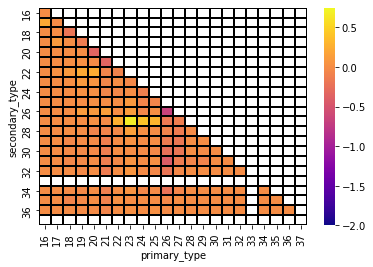

In [65]:
sns.heatmap(df_avgdiffprim_hig_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_hig_T.mean(axis = 0, skipna = True).mean())

-0.009111838717922066


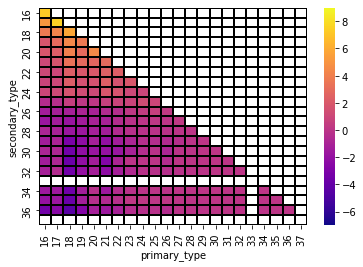

In [66]:
sns.heatmap(df_avgdiffseco_hig_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_hig_T.mean(axis = 0, skipna = True).mean())

0.21104653009094615


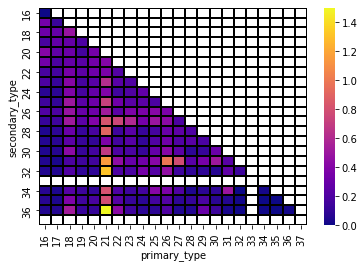

In [67]:
sns.heatmap(df_stdprim_hig_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_hig_T.mean(axis = 0, skipna = True).mean())

0.6702353630467103


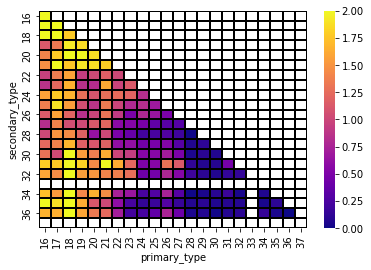

In [68]:
sns.heatmap(df_stdseco_hig_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_hig_T.mean(axis = 0, skipna = True).mean())

409
409


{'primary_type': {'wavegrid': [0.9471239,
   1.099546,
   1.1244725,
   1.128654,
   1.1328428,
   2.3483794],
  'importance': [0.03549109951053762,
   0.09690363260269844,
   0.20765673296988307,
   0.33183186754943084,
   0.05544266259127315,
   0.128127184903187]},
 'secondary_type': {'wavegrid': [1.1496657,
   1.1581149,
   1.1835947,
   1.1878585,
   1.3256073,
   1.6226279,
   1.6700326,
   1.6778415],
  'importance': [0.013415415166993162,
   0.024223994005542804,
   0.2150353816742601,
   0.08126695518229277,
   0.04886215816178999,
   0.02225656834443945,
   0.011130238342230923,
   0.015572662226541882]}}

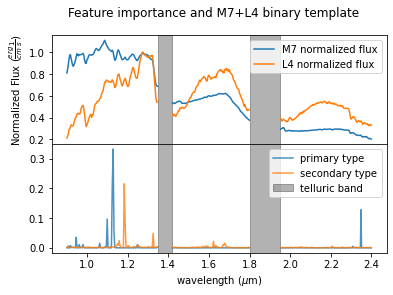

In [85]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = f17hig
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i]=np.nan
ax[0].plot(wvgrd,xarr)
xarr = f24hig
for i in tm:
    xarr[i]=np.nan
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])

feat_impts_hig_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_hig_T.estimators_:
    tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    print(len(FI))
    ax[1].plot(wvgrd,FI, alpha=0.8)
    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        dd.append(wvgrd[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type', 'telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')
feat_impts_hig_T['primary_type']['wavegrid'] = ddd[0]
feat_impts_hig_T['primary_type']['importance'] = eee[0]
feat_impts_hig_T['secondary_type']['wavegrid'] = ddd[1]
feat_impts_hig_T['secondary_type']['importance'] = eee[1]
feat_impts_hig_T

In [70]:
precisionprim_higT1, recallprim_higT1, f1_scoreprim_higT1, accuracyprim_higT1 = calculate_metrics(realprim_hig_T,predsprim_hig_T,1)
precisionsec_higT1, recallsec_higT1, f1_scoresec_higT1, accuracysec_higT1 = calculate_metrics(realsec_hig_T,predssec_hig_T,1)
precisionprim_higT3, recallprim_higT3, f1_scoreprim_higT3, accuracyprim_higT3 = calculate_metrics(realprim_hig_T,predsprim_hig_T,3)
precisionsec_higT3, recallsec_higT3, f1_scoresec_higT3, accuracysec_higT3 = calculate_metrics(realsec_hig_T,predssec_hig_T,3)

In [71]:
with open('data/precisionprim_higT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_higT1, file)
with open('data/recallprim_higT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_higT1, file)
with open('data/f1_scoreprim_higT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_higT1, file)
with open('data/accuracyprim_higT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_higT1, file)

In [72]:
with open('data/precisionsec_higT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_higT1, file)
with open('data/recallsec_higT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_higT1, file)
with open('data/f1_scoresec_higT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_higT1, file)
with open('data/accuracysec_higT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_higT1, file)

In [73]:
with open('data/precisionprim_higT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_higT3, file)
with open('data/recallprim_higT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_higT3, file)
with open('data/f1_scoreprim_higT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_higT3, file)
with open('data/accuracyprim_higT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_higT3, file)

In [74]:
with open('data/precisionsec_higT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_higT3, file)
with open('data/recallsec_higT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_higT3, file)
with open('data/f1_scoresec_higT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_higT3, file)
with open('data/accuracysec_higT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_higT3, file)

LOW, TELLURIC + DIFF

In [15]:
with open('data/BinDF_low_d.pickle', 'rb') as f:
        BinDF_low_d = pickle.load(f)

In [16]:
start = time.time()
clflow_d_T, data_low_d_T = binary_multiOutput_classifier(BinDF_low_d,difference=True,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

1590.748018503189


In [17]:
len(data_low_d_T['x_test'][0])

702

In [18]:
yput1 = []
yput2 = []
for i in data_low_d_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_low_d_T_df = pd.DataFrame(data_low_d_T['x_test'])
data_low_d_T_df['prim']=yput1
data_low_d_T_df['seco']=yput2
data_low_d_T_df.to_csv('data/data_low_d_T_50est.csv',index=False)

In [19]:
x_test_low_d_T = data_low_d_T['x_test']
y_test_low_d_T = data_low_d_T['y_test']

In [20]:
joblib.dump(clflow_d_T, 'MOclassifiers/MO_low_d_T_50est.pkl')

['MOclassifiers/MO_low_d_T_50est.pkl']

In [21]:
MO_low_d_T = joblib.load('MOclassifiers/MO_low_d_T_50est.pkl')

In [22]:
# df_data_low_d_T = pd.read_csv(r'data/data_low_d_T.csv')
# x_test_low_d_T = [[df_data_low_d_T[str(col)][i] for col in range(702)] for i in range(len(df_data_low_d_T))]
# y_test_low_d_T = [[df_data_low_d_T['prim'][i],df_data_low_d_T['seco'][i]] for i in range(len(df_data_low_d_T))]

In [23]:
start = time.time()
df_avgdiffprim_low_d_T, df_avgdiffseco_low_d_T, df_stdprim_low_d_T, df_stdseco_low_d_T, predsprim_low_d_T, predssec_low_d_T, realprim_low_d_T, realsec_low_d_T = binaryPrecision(x_test_low_d_T,y_test_low_d_T,MO_low_d_T, predictions=True)
end = time.time()
print(end-start)

73.08285164833069


-0.05691322446015653


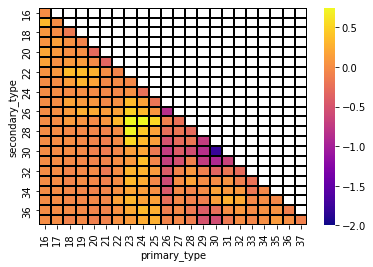

In [24]:
sns.heatmap(df_avgdiffprim_low_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_low_d_T.mean(axis = 0, skipna = True).mean())

-0.04121198250187929


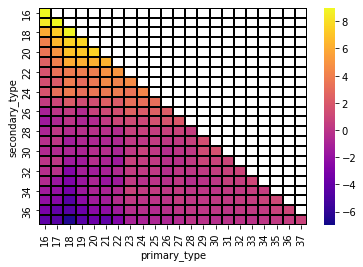

In [25]:
sns.heatmap(df_avgdiffseco_low_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_low_d_T.mean(axis = 0, skipna = True).mean())

0.4123426515214244


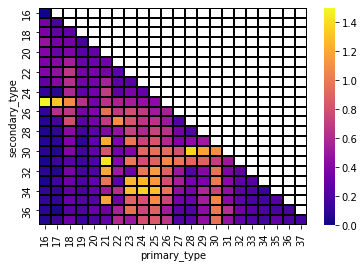

In [26]:
sns.heatmap(df_stdprim_low_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_low_d_T.mean(axis = 0, skipna = True).mean())

1.0702753544754657


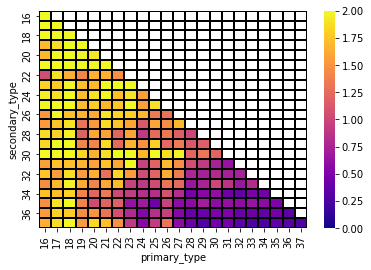

In [27]:
sns.heatmap(df_stdseco_low_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_low_d_T.mean(axis = 0, skipna = True).mean())

Text(0.5, 0, 'wavelength ($\\mu$m)')

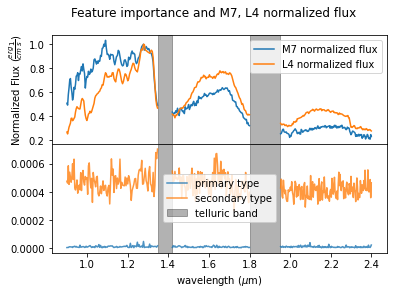

In [28]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

# xarr = x_test_low_d_T[8]
# tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
# for i in tm:
#     xarr1 = list(xarr[:i])
#     xarr2 = list(xarr[i:])
#     xarr  = xarr1 + [np.nan] + xarr2
# for i in tm:
#     xarr1 = list(xarr[:(i+len(wvgrd))])
#     xarr2 = list(xarr[(i+len(wvgrd)):])
#     xarr  = xarr1 + [np.nan] + xarr2
# xarr = np.array(xarr)
# ax[0].plot(wvgrd,xarr[:409])
# ax[0].plot(wvgrd,xarr[409:],c='k')
# ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')



xarr = f17low
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = f24low
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])


feat_impts_low_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_low_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[:409], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7, L4 normalized flux')
plt.xlabel('wavelength ($\mu$m)')

Text(0.5, 0, 'wavelength ($\\mu$m)')

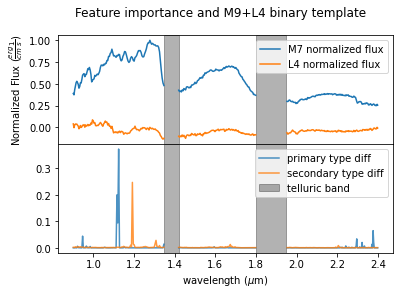

In [29]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave


xarr = binlow
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = dlow
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])


feat_impts_low_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []

for clf in MO_low_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[409:], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type diff', 'secondary type diff','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M9+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [30]:
precisionprim_lowdT1, recallprim_lowdT1, f1_scoreprim_lowdT1, accuracyprim_lowdT1 = calculate_metrics(realprim_low_d_T,predsprim_low_d_T,1)
precisionsec_lowdT1, recallsec_lowdT1, f1_scoresec_lowdT1, accuracysec_lowdT1 = calculate_metrics(realsec_low_d_T,predssec_low_d_T,1)
precisionprim_lowdT3, recallprim_lowdT3, f1_scoreprim_lowdT3, accuracyprim_lowdT3 = calculate_metrics(realprim_low_d_T,predsprim_low_d_T,3)
precisionsec_lowdT3, recallsec_lowdT3, f1_scoresec_lowdT3, accuracysec_lowdT3 = calculate_metrics(realsec_low_d_T,predssec_low_d_T,3)

In [31]:
with open('data/precisionprim_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_lowdT1, file)
with open('data/recallprim_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_lowdT1, file)
with open('data/f1_scoreprim_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_lowdT1, file)
with open('data/accuracyprim_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_lowdT1, file)

In [32]:
with open('data/precisionsec_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_lowdT1, file)
with open('data/recallsec_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_lowdT1, file)
with open('data/f1_scoresec_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_lowdT1, file)
with open('data/accuracysec_lowdT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_lowdT1, file)

In [33]:
with open('data/precisionprim_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_lowdT3, file)
with open('data/recallprim_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_lowdT3, file)
with open('data/f1_scoreprim_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_lowdT3, file)
with open('data/accuracyprim_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_lowdT3, file)

In [34]:
with open('data/precisionsec_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_lowdT3, file)
with open('data/recallsec_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_lowdT3, file)
with open('data/f1_scoresec_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_lowdT3, file)
with open('data/accuracysec_lowdT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_lowdT3, file)

MID, TELLURIC + Diff

In [35]:
with open('data/BinDF_mid_d.pickle', 'rb') as f:
        BinDF_mid_d = pickle.load(f)

In [36]:
start = time.time()
clfmid_d_T, data_mid_d_T = binary_multiOutput_classifier(BinDF_mid_d,difference=True,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

1435.2933411598206


In [37]:
len(data_mid_d_T['x_test'][0])

702

In [38]:
yput1 = []
yput2 = []
for i in data_mid_d_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_mid_d_T_df = pd.DataFrame(data_mid_d_T['x_test'])
data_mid_d_T_df['prim']=yput1
data_mid_d_T_df['seco']=yput2
data_mid_d_T_df.to_csv('data/data_mid_d_T_50est.csv',index=False)

In [39]:
x_test_mid_d_T = data_mid_d_T['x_test']
y_test_mid_d_T = data_mid_d_T['y_test']
print(len(x_test_mid_d_T))

16560


In [40]:
joblib.dump(clfmid_d_T, 'MOclassifiers/MO_mid_d_T_50est.pkl')

['MOclassifiers/MO_mid_d_T_50est.pkl']

In [41]:
MO_mid_d_T = joblib.load('MOclassifiers/MO_mid_d_T_50est.pkl')

In [42]:
# df_data_mid_d_T = pd.read_csv(r'data/data_mid_d_T.csv')
# x_test_mid_d_T = [[df_data_mid_d_T[str(col)][i] for col in range(702)] for i in range(len(df_data_mid_d_T))]
# y_test_mid_d_T = [[df_data_mid_d_T['prim'][i],df_data_mid_d_T['seco'][i]] for i in range(len(df_data_mid_d_T))]

In [43]:
start = time.time()
df_avgdiffprim_mid_d_T, df_avgdiffseco_mid_d_T, df_stdprim_mid_d_T, df_stdseco_mid_d_T, predsprim_mid_d_T, predssec_mid_d_T, realprim_mid_d_T, realsec_mid_d_T = binaryPrecision(x_test_mid_d_T,y_test_mid_d_T,MO_mid_d_T, predictions=True)
end = time.time()
print(end-start)

62.32265377044678


-0.033422745537326694


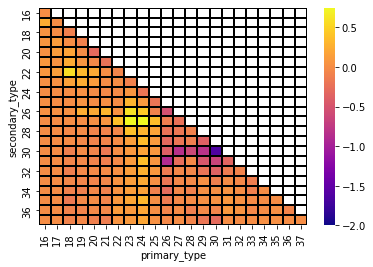

In [44]:
sns.heatmap(df_avgdiffprim_mid_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_mid_d_T.mean(axis = 0, skipna = True).mean())

-0.0250135922488218


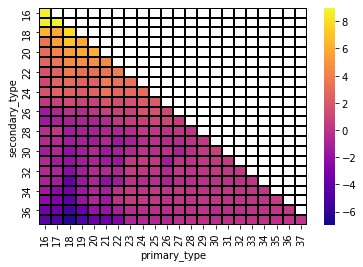

In [45]:
sns.heatmap(df_avgdiffseco_mid_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_mid_d_T.mean(axis = 0, skipna = True).mean())

0.32843286690695656


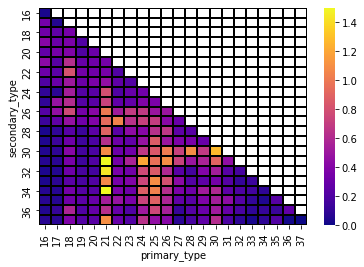

In [46]:
sns.heatmap(df_stdprim_mid_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_mid_d_T.mean(axis = 0, skipna = True).mean())

0.8952897024911453


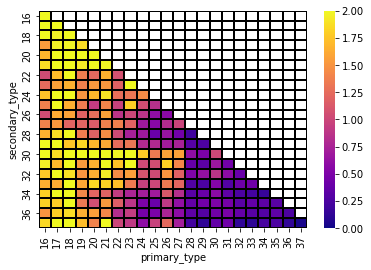

In [47]:
sns.heatmap(df_stdseco_mid_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_mid_d_T.mean(axis = 0, skipna = True).mean())

Text(0.5, 0, 'wavelength ($\\mu$m)')

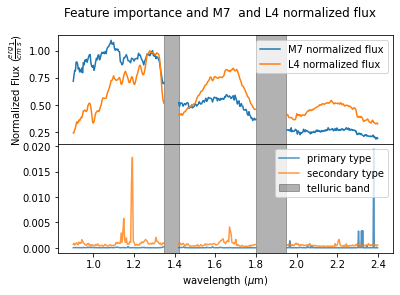

In [48]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = f17mid
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = f24mid
for i in tm:
    xarr[i] = np.nan
xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])

feat_impts_mid_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_mid_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[:409], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7  and L4 normalized flux')
plt.xlabel('wavelength ($\mu$m)')

Text(0.5, 0, 'wavelength ($\\mu$m)')

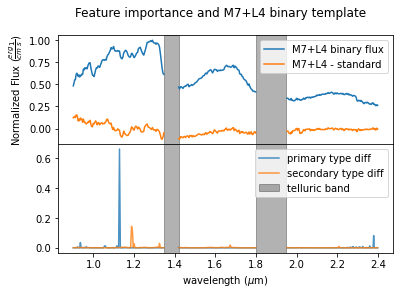

In [49]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = binmid
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = dmid
for i in tm:
    xarr[i] = np.nan
xarr = np.array(xarr)
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7+L4 binary flux','M7+L4 - standard'])

feat_impts_mid_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []

for clf in MO_mid_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[409:], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type diff', 'secondary type diff','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [50]:
precisionprim_middT1, recallprim_middT1, f1_scoreprim_middT1, accuracyprim_middT1 = calculate_metrics(realprim_mid_d_T,predsprim_mid_d_T,1)
precisionsec_middT1, recallsec_middT1, f1_scoresec_middT1, accuracysec_middT1 = calculate_metrics(realsec_mid_d_T,predssec_mid_d_T,1)
precisionprim_middT3, recallprim_middT3, f1_scoreprim_middT3, accuracyprim_middT3 = calculate_metrics(realprim_mid_d_T,predsprim_mid_d_T,3)
precisionsec_middT3, recallsec_middT3, f1_scoresec_middT3, accuracysec_middT3 = calculate_metrics(realsec_mid_d_T,predssec_mid_d_T,3)

In [51]:
with open('data/precisionprim_middT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_middT1, file)
with open('data/recallprim_middT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_middT1, file)
with open('data/f1_scoreprim_middT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_middT1, file)
with open('data/accuracyprim_middT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_middT1, file)

In [52]:
with open('data/precisionsec_middT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_middT1, file)
with open('data/recallsec_middT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_middT1, file)
with open('data/f1_scoresec_middT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_middT1, file)
with open('data/accuracysec_middT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_middT1, file)

In [53]:
with open('data/precisionprim_middT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_middT3, file)
with open('data/recallprim_middT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_middT3, file)
with open('data/f1_scoreprim_middT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_middT3, file)
with open('data/accuracyprim_middT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_middT3, file)

In [54]:
with open('data/precisionsec_middT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_middT3, file)
with open('data/recallsec_middT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_middT3, file)
with open('data/f1_scoresec_middT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_middT3, file)
with open('data/accuracysec_middT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_middT3, file)

HIG, Telluric + Diff

In [55]:
with open('data/BinDF_hig_d.pickle', 'rb') as f:
        BinDF_hig_d = pickle.load(f)

In [56]:
start = time.time()
clfhig_d_T, data_hig_d_T = binary_multiOutput_classifier(BinDF_hig_d,difference=True,telluric=True,max_depth=25,n_estimators=50,testdata=True)
end = time.time()
print(end-start)

970.0922701358795


In [57]:
len(data_hig_d_T['x_test'][0])

702

In [58]:
yput1 = []
yput2 = []
for i in data_hig_d_T['y_test']:
    yput1.append(i[0])
    yput2.append(i[1])
data_hig_d_T_df = pd.DataFrame(data_hig_d_T['x_test'])
data_hig_d_T_df['prim']=yput1
data_hig_d_T_df['seco']=yput2
data_hig_d_T_df.to_csv('data/data_hig_d_T_50est.csv',index=False)

In [59]:
x_test_hig_d_T = data_hig_d_T['x_test']
y_test_hig_d_T = data_hig_d_T['y_test']
print(len(x_test_hig_d_T))

12600


In [60]:
joblib.dump(clfhig_d_T, 'MOclassifiers/MO_hig_d_T_50est.pkl')

['MOclassifiers/MO_hig_d_T_50est.pkl']

In [61]:
MO_hig_d_T = joblib.load('MOclassifiers/MO_hig_d_T_50est.pkl')

In [62]:
# df_data_hig_d_T = pd.read_csv(r'data/data_hig_d_T.csv')
# x_test_hig_d_T = [[df_data_hig_d_T[str(col)][i] for col in range(702)] for i in range(len(df_data_hig_d_T))]
# y_test_hig_d_T = [[df_data_hig_d_T['prim'][i],df_data_hig_d_T['seco'][i]] for i in range(len(df_data_hig_d_T))]

In [63]:
start = time.time()
df_avgdiffprim_hig_d_T, df_avgdiffseco_hig_d_T, df_stdprim_hig_d_T, df_stdseco_hig_d_T, predsprim_hig_d_T, predssec_hig_d_T, realprim_hig_d_T, realsec_hig_d_T = binaryPrecision(x_test_hig_d_T,y_test_hig_d_T,MO_hig_d_T, predictions=True)
end = time.time()
print(end-start)

45.27505946159363


-0.011598919789692082


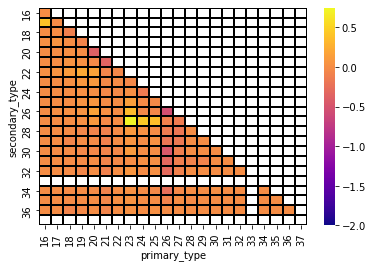

In [64]:
sns.heatmap(df_avgdiffprim_hig_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-2,vmax=0.75)
print(df_avgdiffprim_hig_d_T.mean(axis = 0, skipna = True).mean())

0.006071107992570307


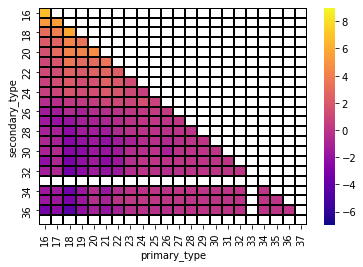

In [65]:
sns.heatmap(df_avgdiffseco_hig_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=-7,vmax=9)
print(df_avgdiffseco_hig_d_T.mean(axis = 0, skipna = True).mean())

0.19926784259479863


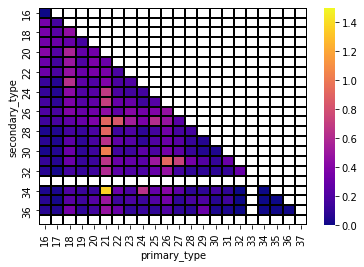

In [66]:
sns.heatmap(df_stdprim_hig_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=1.5)
print(df_stdprim_hig_d_T.mean(axis = 0, skipna = True).mean())

0.6826134780888349


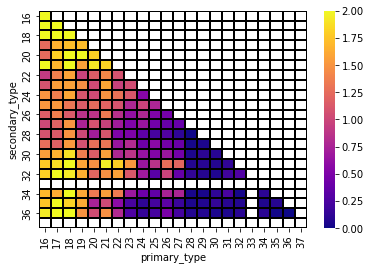

In [67]:
sns.heatmap(df_stdseco_hig_d_T.drop([38,39],axis=1).drop([38,39]),annot=False,linewidths=0.1,linecolor='black', cmap="plasma",vmin=0,vmax=2)
print(df_stdseco_hig_d_T.mean(axis = 0, skipna = True).mean())

Text(0.5, 0, 'wavelength ($\\mu$m)')

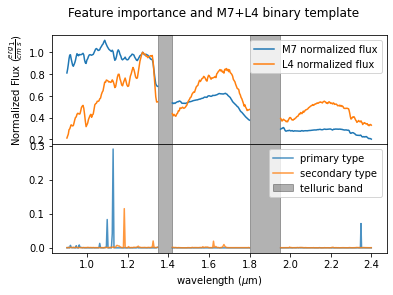

In [68]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = f17hig
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = f24hig
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7 normalized flux','L4 normalized flux'])

feat_impts_hig_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []
for clf in MO_hig_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[:409], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
    
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type', 'secondary type','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')

Text(0.5, 0, 'wavelength ($\\mu$m)')

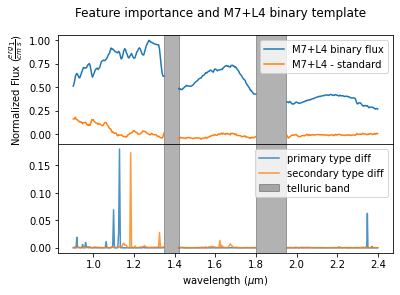

In [69]:
fig, ax = plt.subplots(2,1,sharex=True)

wvgrd = wave

xarr = binhig
tm = list(np.where(np.logical_or(np.logical_and(wvgrd >= 1.35,wvgrd <= 1.42), np.logical_and(wvgrd >= 1.8,wvgrd <= 1.95)))[0])
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
xarr = dhig
for i in tm:
    xarr[i] = np.nan
ax[0].plot(wvgrd,xarr)
ax[0].set_ylabel('Normalized Flux ($\\frac{erg}{cm}\\frac{1}{s}$)')
ax[0].legend(['M7+L4 binary flux','M7+L4 - standard'])

feat_impts_hig_d_T = {'primary_type':{},'secondary_type':{}}
ddd = []
eee = []

for clf in MO_hig_d_T.estimators_:
    FI = clf.feature_importances_
    for i in tm:
        FI1 = list(FI[:i])
        FI2 = list(FI[i:])
        FI  = FI1 + [np.nan] + FI2
    for i in tm:
        FI1 = list(FI[:(i+len(wvgrd))])
        FI2 = list(FI[(i+len(wvgrd)):])
        FI  = FI1 + [np.nan] + FI2
    FI = np.array(FI)
    ax[1].plot(wvgrd,FI[409:], alpha=0.8)

    max_imp = max(FI)
    dd = []
    ee = []
    for i in np.where(FI >= 0.05*max_imp)[0]:
        wvgrd2 = list(wvgrd)+list(wvgrd)
        dd.append(wvgrd2[i])
        ee.append(FI[i])
    ddd.append(dd)
    eee.append(ee)
    
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].legend(['primary type diff', 'secondary type diff','telluric band'])
plt.subplots_adjust(hspace=0)
fig.suptitle('Feature importance and M7+L4 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [70]:
precisionprim_higdT1, recallprim_higdT1, f1_scoreprim_higdT1, accuracyprim_higdT1 = calculate_metrics(realprim_hig_d_T,predsprim_hig_d_T,1)
precisionsec_higdT1, recallsec_higdT1, f1_scoresec_higdT1, accuracysec_higdT1 = calculate_metrics(realsec_hig_d_T,predssec_hig_d_T,1)
precisionprim_higdT3, recallprim_higdT3, f1_scoreprim_higdT3, accuracyprim_higdT3 = calculate_metrics(realprim_hig_d_T,predsprim_hig_d_T,3)
precisionsec_higdT3, recallsec_higdT3, f1_scoresec_higdT3, accuracysec_higdT3 = calculate_metrics(realsec_hig_d_T,predssec_hig_d_T,3)

In [71]:
with open('data/precisionprim_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_higdT1, file)
with open('data/recallprim_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_higdT1, file)
with open('data/f1_scoreprim_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_higdT1, file)
with open('data/accuracyprim_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_higdT1, file)

In [72]:
with open('data/precisionsec_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_higdT1, file)
with open('data/recallsec_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_higdT1, file)
with open('data/f1_scoresec_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_higdT1, file)
with open('data/accuracysec_higdT1_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_higdT1, file)

In [73]:
with open('data/precisionprim_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionprim_higdT3, file)
with open('data/recallprim_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(recallprim_higdT3, file)
with open('data/f1_scoreprim_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoreprim_higdT3, file)
with open('data/accuracyprim_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracyprim_higdT3, file)

In [74]:
with open('data/precisionsec_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(precisionsec_higdT3, file)
with open('data/recallsec_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(recallsec_higdT3, file)
with open('data/f1_scoresec_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(f1_scoresec_higdT3, file)
with open('data/accuracysec_higdT3_50est.pickle', 'wb') as file:
    pickle.dump(accuracysec_higdT3, file)